# Load Relevant Packages

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn import tree

import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from scipy import stats
import spacy
import gensim

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from textmining import TermDocumentMatrix

# Import Data

In [97]:
joined_df = pd.read_csv('joined_final.csv')
print(len(joined_df))
joined_df.head()

2587


,term,course,type,day,time,building,room,time_indicator,start_time,end_time,...,pdf_list,class_engagement,light_work,test_assessment,projects,engagement_percent,light_work_percent,test_percent,projects_percent,rCourseQualityBinned
0,2010a,ACCT101401,LEC,MW,9-10:30AM,JMHH,260,AM,9.0,10.5,...,"['accounting 101 spring 2010 - reis ', '', 'un...",0,10,60,2,0.0,0.138889,0.833333,0.027778,2
1,2010a,ACCT101402,LEC,MW,10:30-12NOON,JMHH,260,NOON,10.5,12.0,...,"['accounting 101 spring 2010 - reis ', '', 'un...",0,10,60,2,0.0,0.138889,0.833333,0.027778,2
2,2010a,ACCT101403,LEC,MW,1:30-3PM,JMHH,250,PM,13.5,15.0,...,"['accounting 101 spring 2010 - reis ', '', 'un...",0,10,60,2,0.0,0.138889,0.833333,0.027778,2
3,2010a,ACCT101410,REC,F,10-11AM,JMHH,G86,AM,10.0,11.0,...,"['accounting 101 spring 2010 - reis ', '', 'un...",0,10,60,2,0.0,0.138889,0.833333,0.027778,2
4,2010a,ACCT101411,REC,F,11-12NOON,JMHH,G86,NOON,11.0,12.0,...,"['accounting 101 spring 2010 - reis ', '', 'un...",0,10,60,2,0.0,0.138889,0.833333,0.027778,2


## Tranform time label of data to categorical variables representating the gradient of the day

In [108]:
def switch_demo(argument):
    switcher = {
        8: "early",
        9: "early",
        10: "early",
        11: "mid-day",
        12: "mid-day",
        13: "mid-day",
        14: "mid-day",
        15: "late-afteroon",
        16: "late-afteroon",
        17: "late-afteroon",
        18: "night"
    }
    return switcher.get(argument, "Invalid month")

switch_demo_vect = np.vectorize(switch_demo)

## One Hot Encode Categorical Variables

In [109]:
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['race'])], axis=1)
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['gender'])], axis=1)
joined_df["start_range"] = switch_demo_vect(joined_df.start_time.astype("int"))
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['start_range'])], axis=1)

## Relabel Column

In [110]:
joined_df.columns.values[56] = "Female"
joined_df.columns.values[55] = "Male"
joined_df.columns.values[54] = "Others"
joined_df.columns.values[53] = "Indian"
joined_df.columns.values[52] = "Asian"
joined_df.columns.values[51] = "Black"
joined_df.columns.values[50] = "White"

## Construct the Department and Course Quality Variable

In [126]:
def first_strings(x,num):
    return x[0:num]
vect_strings = np.vectorize(first_strings)

In [127]:
# function to round number to nearest 0.5
def round_half(number):
    return round(number * 2) / 2

round_half_vect = np.vectorize(round_half)

In [128]:
joined_df['Department'] = vect_strings(joined_df['course'],4)

In [129]:
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['Department'])], axis=1)

In [130]:
joined_df['rCourseQualityBinned'] = round_half_vect(joined_df['rCourseQuality'])

In [131]:
joined_df.columns

Index(['term', 'course', 'type', 'day', 'time', 'building', 'room',
       'time_indicator', 'start_time', 'end_time', 'class_duration',
       'instructor', 'num_reviewers', 'num_students', 'rAmountLearned',
       'rCommAbility', 'rCourseQuality', 'rDifficulty', 'rInstructorAccess',
       'rInstructorQuality', 'rReadingsValue', 'rRecommendMajor',
       'rRecommendNonMajor', 'rStimulateInterest', 'rTAQuality',
       'rWorkRequired', 'race', 'gender', 'F', 'M', 'MW', 'R', 'T', 'TR', 'W',
       'JMHH', 'SHDH', 'VANC', 'url', 'pdf_content', 'pdf_list',
       'class_engagement', 'light_work', 'test_assessment', 'projects',
       'engagement_percent', 'light_work_percent', 'test_percent',
       'projects_percent', 'rCourseQualityBinned', 'White', 'Black', 'Asian',
       'Indian', 'Others', 'Male', 'Female', 'start_range', 'early',
       'late-afteroon', 'mid-day', 'night', 'Department', 'ACCT', 'BEPP',
       'FNCE', 'HCMG', 'LGST', 'MGMT', 'MKTG', 'OIDD', 'REAL', 'STAT', 'ACCT',


## General Grade Distribution

(array([ 11.,  25.,  83., 250., 471., 522., 568., 394., 201.,  62.]),
 array([0.76 , 1.084, 1.408, 1.732, 2.056, 2.38 , 2.704, 3.028, 3.352,
        3.676, 4.   ]),
 <a list of 10 Patch objects>)

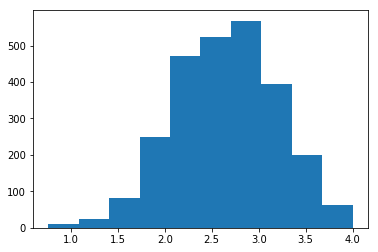

In [117]:
plt.hist(joined_df['rCourseQuality'])

# On Race

In [118]:
dist_race = joined_df.groupby(['race',"rCourseQualityBinned"]).agg({"term":"count"}).reset_index()

In [119]:
#df = df[['gene_symbol', 'sample_id', 'fc']]
value_spread = dist_race.pivot(index='race',columns='rCourseQualityBinned',values='term').fillna(0).reset_index()
value_spread['race'] = ['White','Black','Asian','Indian','Others']

In [120]:
value_spread

rCourseQualityBinned,race,1.0,1.5,2.0,2.5,3.0,3.5,4.0
0,White,11.0,67.0,326.0,554.0,565.0,273.0,34.0
1,Black,0.0,3.0,7.0,18.0,29.0,15.0,0.0
2,Asian,6.0,25.0,118.0,138.0,90.0,18.0,1.0
3,Indian,0.0,3.0,43.0,58.0,74.0,19.0,0.0
4,Others,1.0,8.0,25.0,28.0,20.0,8.0,2.0


In [121]:
def create_sliced_df(x,y,z):
    value_a= y[y[z] == x]
    list_a = ["Other"] + list(np.array(y[y[z] != x].iloc[:,1:len(y.columns)].sum()))
    value_a = value_a.append(pd.Series(list_a,index = y.columns),ignore_index = True)
    return value_a

In [122]:
def make_hist(x,y,z):
    dist1 = (joined_df[joined_df[x] == 1]['rCourseQuality'])
    dist2 = (joined_df[joined_df[x] == 0]['rCourseQuality'])
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax1.hist(dist1)
    ax1.set_title(x)
    ax2.hist(dist2)
    ax2.set_title("others")

In [123]:
def chi_square(x,y,z):
    chi_stats = stats.chi2_contingency(np.array(create_sliced_df(x,y,z).iloc[:,1:len(y.columns)]))
    j = pd.DataFrame({"chi_stats":[chi_stats[0],"","",""],"p_value":[chi_stats[1],"","",""]})
    q = pd.DataFrame(stats.chi2_contingency(np.array(create_sliced_df(x,y,z).iloc[:,1:len(y.columns)]))[3], columns = y.iloc[:,1:len(y.columns)].columns)
    make_hist(x,y,z)
    return(pd.concat([create_sliced_df(x,y,z).append(q,sort=False).fillna("Expected").reset_index(drop=True), 
                      j.reset_index(drop=True)], axis = 1))

,race,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,White,11.000000,67.000000,326.000000,554.000000,565.000000,273.000000,34.000000,49.6289,5.57909e-09
1,Other,7.000000,39.000000,193.000000,242.000000,213.000000,60.000000,3.000000,,
2,Expected,12.732895,74.982605,367.131813,563.076923,550.344028,235.558562,26.173174,,
3,Expected,5.267105,31.017395,151.868187,232.923077,227.655972,97.441438,10.826826,,


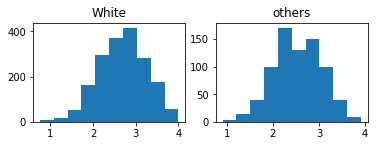

In [124]:
#Others were significantly lower than expected amount
chi_square("White",value_spread,'race')

,race,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,Black,0.000000,3.000000,7.00000,18.000000,29.00000,15.000000,0.000000,12.5343,0.0510562
1,Other,18.000000,103.000000,512.00000,778.000000,749.00000,318.000000,37.000000,,
2,Expected,0.500966,2.950135,14.44453,22.153846,21.65288,9.267878,1.029764,,
3,Expected,17.499034,103.049865,504.55547,773.846154,756.34712,323.732122,35.970236,,


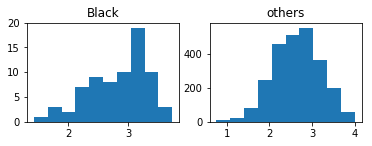

In [125]:
#Lacking in quantity leading results to be less significant
chi_square("Black",value_spread,'race')

,race,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,Asian,6.000000,25.000000,118.000000,138.000000,90.000000,18.000000,1.000000,72.845,1.06527e-13
1,Other,12.000000,81.000000,401.000000,658.000000,688.000000,315.000000,36.000000,,
2,Expected,2.755315,16.225744,79.444917,121.846154,119.090839,50.973328,5.663703,,
3,Expected,15.244685,89.774256,439.555083,674.153846,658.909161,282.026672,31.336297,,


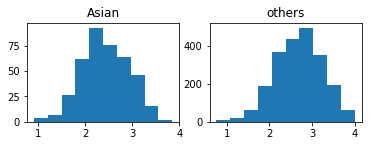

In [26]:
#Ratings for Asians are disproportionately lower on the higher ends
chi_square("Asian",value_spread,'race')

,race,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,Indian,0.0000,3.000000,43.00000,58.000000,74.000000,19.000000,0.000000,14.1399,0.0281124
1,Other,18.0000,103.000000,476.00000,738.000000,704.000000,314.000000,37.000000,,
2,Expected,1.3707,8.071898,39.52184,60.615385,59.244685,25.357944,2.817549,,
3,Expected,16.6293,97.928102,479.47816,735.384615,718.755315,307.642056,34.182451,,


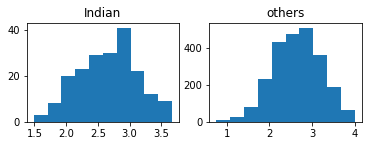

In [27]:
#Okay
chi_square("Indian",value_spread,'race')

,race,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,Others,1.000000,8.000000,25.0000,28.000000,20.000000,8.000000,2.00000,11.4057,0.0766194
1,Other,17.000000,98.000000,494.0000,768.000000,758.000000,325.000000,35.00000,,
2,Expected,0.640124,3.769617,18.4569,28.307692,27.667569,11.842288,1.31581,,
3,Expected,17.359876,102.230383,500.5431,767.692308,750.332431,321.157712,35.68419,,


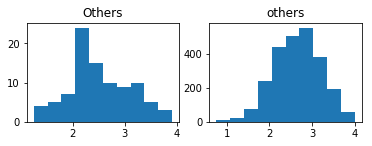

In [28]:
#Okay
chi_square("Others",value_spread,'race')

In [29]:
import numpy as np, statsmodels.stats.api as sms

In [30]:
def t_test(x):
    cm = sms.CompareMeans(sms.DescrStatsW(joined_df[joined_df[x] == 1]['rCourseQuality']), sms.DescrStatsW(joined_df[joined_df[x] == 0]['rCourseQuality']))
    mean1 = (joined_df[joined_df[x] == 1]['rCourseQuality'].mean())
    mean2 = (joined_df[joined_df[x] == 0]['rCourseQuality'].mean())
    t_test_result = (stats.ttest_ind(joined_df[joined_df[x] == 1]['rCourseQuality'],joined_df[joined_df[x] == 0]['rCourseQuality']))
    t_test_conf=(cm.tconfint_diff(usevar='unequal'))
    return pd.DataFrame({"of_interest" : [x, "Others"],
                        "mean":[mean1, mean2],
                          "t_stats":[t_test_result[0],""],
                         "p_value":[t_test_result[1],""],
                         "conf_interval_lb" :[t_test_conf[0],""],
                         "conf_interval_ub" :[t_test_conf[1],""]})

In [31]:
t_test("Asian")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,Asian,2.431717,-8.54382,2.18358e-17,-0.306459,-0.19782
1,Others,2.683857,,,,


In [32]:
t_test("White")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,White,2.689710,6.46576,1.20088e-10,0.107013,0.196794
1,Others,2.537807,,,,


In [33]:
t_test("Black")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,Black,2.832083,2.93861,0.00332606,0.0698732,0.314468
1,Others,2.639913,,,,


In [34]:
t_test("Indian")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,Indian,2.661320,0.427914,0.668749,-0.0508054,0.0855705
1,Others,2.643937,,,,


In [35]:
t_test("Others")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,Others,2.499674,-2.598,0.00943009,-0.275443,-0.0264672
1,Others,2.650629,,,,


In [36]:
joined_df[joined_df['Black'] == 1][['instructor','rCourseQuality']].groupby('instructor').agg({"rCourseQuality":["count","mean"]})

rCourseQuality          
                               count      mean
instructor                                    
Chinelo N Mba                      3  1.983333
Jose F. Anderson                   8  3.080000
Keisha M. Cutright                 9  3.195556
Kenneth L. Shropshire              7  3.200000
Kwame A Danso                      6  2.043333
Louis A Thomas                     7  2.420000
Mariaflavia Harari                10  2.508000
Mason P Ashe                       3  3.140000
Prasanna Tambe                     3  3.370000
Shern I Frederick                  4  2.625000
Stephan Dieckmann                 10  3.089000
Stephanie J. Creary                2  3.480000

# On Gender

In [37]:
def create_sliced_df2(x,y,z):
    value_a= y[y[z] == x]
    list_a = ["Female"] + list(np.array(y[y[z] != x].iloc[:,1:len(y.columns)].sum()))
    value_a = value_a.append(pd.Series(list_a,index = y.columns),ignore_index = True)
    return value_a

In [38]:
def make_hist2(x,y,z):
    dist1 = (joined_df[joined_df[x] == 1]['rCourseQuality'])
    dist2 = (joined_df[joined_df[x] == 0]['rCourseQuality'])
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax1.hist(dist1)
    ax1.set_title(x)
    ax2.hist(dist2)
    ax2.set_title("Female")

In [39]:
def chi_square2(x,y,z):
    chi_stats = stats.chi2_contingency(np.array(create_sliced_df(x,y,z).iloc[:,1:len(y.columns)]))
    j = pd.DataFrame({"chi_stats":[chi_stats[0],"","",""],"p_value":[chi_stats[1],"","",""]})
    q = pd.DataFrame(stats.chi2_contingency(np.array(create_sliced_df2(x,y,z).iloc[:,1:len(y.columns)]))[3], columns = y.iloc[:,1:len(y.columns)].columns)
    make_hist2(x,y,z)
    return(pd.concat([create_sliced_df2(x,y,z).append(q,sort=False).fillna("Expected").reset_index(drop=True), 
                      j.reset_index(drop=True)], axis = 1))

In [40]:
def t_test2(x):
    cm = sms.CompareMeans(sms.DescrStatsW(joined_df[joined_df[x] == 1]['rCourseQuality']), sms.DescrStatsW(joined_df[joined_df[x] == 0]['rCourseQuality']))
    mean1 = (joined_df[joined_df[x] == 1]['rCourseQuality'].mean())
    mean2 = (joined_df[joined_df[x] == 0]['rCourseQuality'].mean())
    t_test_result = (stats.ttest_ind(joined_df[joined_df[x] == 1]['rCourseQuality'],joined_df[joined_df[x] == 0]['rCourseQuality']))
    t_test_conf=(cm.tconfint_diff(usevar='unequal'))
    return pd.DataFrame({"of_interest" : [x, "Female"],
                        "mean":[mean1, mean2],
                          "t_stats":[t_test_result[0],""],
                         "p_value":[t_test_result[1],""],
                         "conf_interval_lb" :[t_test_conf[0],""],
                         "conf_interval_ub" :[t_test_conf[1],""]})

In [41]:
dist_gender = joined_df.groupby(['gender','rCourseQualityBinned']).agg({"term":"count"}).reset_index()

In [42]:
value_spreads = dist_gender.pivot(index='gender',columns='rCourseQualityBinned',values='term').fillna(0).reset_index()
value_spreads['gender'] = ['Male',"Female"]
value_spreads

rCourseQualityBinned,gender,1.0,1.5,2.0,2.5,3.0,3.5,4.0
0,Male,13,77,325,534,520,263,32
1,Female,5,29,194,262,258,70,5


In [43]:
value_spreads

rCourseQualityBinned,gender,1.0,1.5,2.0,2.5,3.0,3.5,4.0
0,Male,13,77,325,534,520,263,32
1,Female,5,29,194,262,258,70,5


,gender,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,Male,13.000000,77.000000,325.000000,534.000000,520.000000,263.000000,32.000000,33.2071,9.56615e-06
1,Female,5.000000,29.000000,194.000000,262.000000,258.000000,70.000000,5.000000,,
2,Expected,12.273676,72.278315,353.890993,542.769231,530.495555,227.063007,25.229223,,
3,Expected,5.726324,33.721685,165.109007,253.230769,247.504445,105.936993,11.770777,,


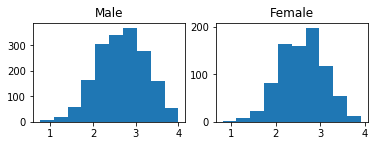

In [44]:
chi_square2("Male",value_spreads,'gender')

In [45]:
t_test2("Male")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,Male,2.671627,3.59143,0.000335001,0.0396725,0.126084
1,Female,2.588748,,,,


# On Race x Gender

In [46]:
dist_race_gender = joined_df.groupby(['race',"gender","rCourseQualityBinned"]).agg({"term":"count"}).reset_index()

In [47]:
dist_race_gender.loc[dist_race_gender['race'] == 0,'race'] = 'White'
dist_race_gender.loc[dist_race_gender['race'] == 1,'race'] = 'Black'
dist_race_gender.loc[dist_race_gender['race'] == 2,'race'] = 'Asian'
dist_race_gender.loc[dist_race_gender['race'] == 3,'race'] = 'Indian'
dist_race_gender.loc[dist_race_gender['race'] == 4,'race'] = 'Others'
dist_race_gender.loc[dist_race_gender['gender'] == 0,'gender'] = 'Male'
dist_race_gender.loc[dist_race_gender['gender'] == 1,'gender'] = 'Female'

In [48]:
value_spread_layer = dist_race_gender.pivot_table(values='term', 
        index=['race', 'gender'], 
        columns='rCourseQualityBinned').fillna(0).reset_index()

In [49]:
def create_sliced_df_layered(w,x,y):
    value_a= y[(y["race"] == x) & (y["gender"] == w)]
    list_a = ["Everything Else","Everything Else"] + list(np.array((y[(y["race"] != x) | (y["gender"] != w)].iloc[:,2:9].sum())))
    value_a = value_a.append(pd.Series(list_a,index = y.columns),ignore_index = True)
    return value_a

def make_hist1(w,x,y):
    dist1 = joined_df[(joined_df[w] == 1)&(joined_df[x] == 1)]['rCourseQuality']
    dist2 = joined_df[(joined_df[w] == 0)|(joined_df[x] == 0)]['rCourseQuality']
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax1.hist(dist1)
    ax1.set_title(w+x)
    ax2.hist(dist2)
    ax2.set_title("others")

def chi_square_layered(w,x,y):
    chi_stats = (stats.chi2_contingency(np.array(create_sliced_df_layered(w,x,y).iloc[:,2:9])))
    j = pd.DataFrame({"chi_stats":[chi_stats[0],"","",""],"p_value":[chi_stats[1],"","",""]})
    z = pd.DataFrame(stats.chi2_contingency(np.array(create_sliced_df_layered(w,x,y).iloc[:,2:9]))[3], columns = y.iloc[:,2:9].columns)
    make_hist1(w,x,y)
    return(pd.concat([create_sliced_df_layered(w,x,y).append(z,sort=False).fillna("Expected").reset_index(drop=True), 
                      j.reset_index(drop=True)], axis = 1))


,race,gender,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,Asian,Male,3.000000,13.000000,53.000000,60.0,28.000000,11.000000,1.000000,39.0963,6.85303e-07
1,Everything Else,Everything Else,15.000000,93.000000,466.000000,736.0,750.000000,322.000000,36.000000,,
2,Expected,Expected,1.175879,6.924623,33.904523,52.0,50.824121,21.753769,2.417085,,
3,Expected,Expected,16.824121,99.075377,485.095477,744.0,727.175879,311.246231,34.582915,,


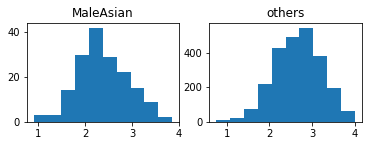

In [50]:
chi_square_layered("Male","Asian",value_spread_layer)

,race,gender,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,Asian,Female,3.000000,12.000000,65.000000,78.000000,62.000000,7.000000,0.000000,35.1287,4.06905e-06
1,Everything Else,Everything Else,15.000000,94.000000,454.000000,718.000000,716.000000,326.000000,37.000000,,
2,Expected,Expected,1.579436,9.301121,45.540394,69.846154,68.266718,29.219559,3.246618,,
3,Expected,Expected,16.420564,96.698879,473.459606,726.153846,709.733282,303.780441,33.753382,,


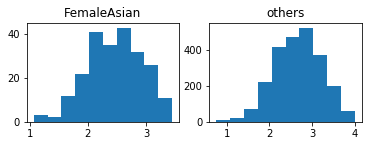

In [51]:
chi_square_layered("Female","Asian",value_spread_layer)

In [52]:
def t_test_layered(x,y):
    mean1 = joined_df[(joined_df[x] == 1)&(joined_df[y] == 1)]['rCourseQuality'].mean()
    mean2 = joined_df[(joined_df[x] == 0)|(joined_df[y] == 0)]['rCourseQuality'].mean()
    t_test_result = stats.ttest_ind(joined_df[(joined_df[x] == 1)&(joined_df[y] == 1)]['rCourseQuality'],
                          joined_df[(joined_df[x] == 0)|(joined_df[y] == 0)]['rCourseQuality'])
    cm = sms.CompareMeans(sms.DescrStatsW(joined_df[(joined_df[x] == 1)&(joined_df[y] == 1)]['rCourseQuality']), 
                          sms.DescrStatsW(joined_df[(joined_df[x] == 0)|(joined_df[y] == 0)]['rCourseQuality']))
    t_test_conf = cm.tconfint_diff(usevar='unequal')
    return pd.DataFrame({"of_interest" : [x + y, "Others"],
                        "mean":[mean1, mean2],
                          "t_stats":[t_test_result[0],""],
                         "p_value":[t_test_result[1],""],
                         "conf_interval_lb" :[t_test_conf[0],""],
                         "conf_interval_ub" :[t_test_conf[1],""]})

In [53]:
t_test_layered("Asian","Male")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,AsianMale,2.379467,-6.57587,5.83172e-11,-0.367739,-0.201002
1,Others,2.663838,,,,


In [54]:
t_test_layered("Asian","Female")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,AsianFemale,2.470617,-5.05168,4.68479e-07,-0.256935,-0.12595
1,Others,2.662059,,,,


In [55]:
t_test_layered("Indian","Male")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,IndianMale,2.711597,1.35236,0.176377,-0.0147516,0.15382
1,Others,2.642062,,,,


In [56]:
t_test_layered("Indian","Female")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,IndianFemale,2.584615,-0.992591,0.321002,-0.169869,0.0448075
1,Others,2.647146,,,,


In [57]:
t_test_layered("White","Male")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,WhiteMale,2.704714,5.86586,5.03786e-09,0.0840009,0.16752
1,Others,2.578953,,,,


In [58]:
t_test_layered("White","Female")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,WhiteFemale,2.645794,0.0231899,0.981501,-0.0493342,0.0506346
1,Others,2.645144,,,,


In [59]:
t_test_layered("Black","Female")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,BlackFemale,2.976429,2.26943,0.0233245,0.00287985,0.663059
1,Others,2.643459,,,,


In [60]:
t_test_layered("Black","Male")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,BlackMale,2.797241,2.13797,0.0326123,0.0231999,0.287732
1,Others,2.641775,,,,


In [61]:
t_test_layered("Others","Female")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,OthersFemale,2.460526,-2.09515,0.0362547,-0.417103,0.0421262
1,Others,2.648015,,,,


In [62]:
t_test_layered("Others","Male")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,OthersMale,2.527222,-1.60033,0.109647,-0.261993,0.0208829
1,Others,2.647777,,,,


# On Start Time

In [63]:
dist_start = joined_df.groupby(['start_range',"rCourseQualityBinned"]).agg({"term":"count"}).reset_index()

#df = df[['gene_symbol', 'sample_id', 'fc']]
value_spread2 = dist_start.pivot(index='start_range',columns='rCourseQualityBinned',values='term').fillna(0).reset_index()
value_spread2

rCourseQualityBinned,start_range,1.0,1.5,2.0,2.5,3.0,3.5,4.0
0,early,7.0,25.0,131.0,258.0,242.0,119.0,10.0
1,late-afteroon,2.0,10.0,78.0,165.0,202.0,102.0,24.0
2,mid-day,9.0,71.0,310.0,373.0,331.0,111.0,3.0
3,night,0.0,0.0,0.0,0.0,3.0,1.0,0.0


,start_range,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,early,7.00000,25.000000,131.000000,258.000000,242.000000,119.000000,10.000000,15.736,0.0152435
1,Other,11.00000,81.000000,388.000000,538.000000,536.000000,214.000000,27.000000,,
2,Expected,5.51063,32.451488,158.889834,243.692308,238.181678,101.946656,11.327406,,
3,Expected,12.48937,73.548512,360.110166,552.307692,539.818322,231.053344,25.672594,,


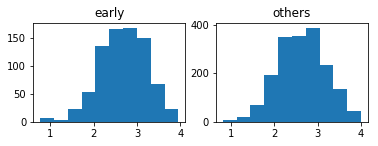

In [64]:
chi_square("early",value_spread2,'start_range')

,start_range,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,mid-day,9.000000,71.000000,310.00000,373.000000,331.000000,111.000000,3.000000,104.444,2.96181e-20
1,Other,9.000000,35.000000,209.00000,423.000000,447.000000,222.000000,34.000000,,
2,Expected,8.405102,49.496714,242.34712,371.692308,363.287205,155.494395,17.277155,,
3,Expected,9.594898,56.503286,276.65288,424.307692,414.712795,177.505605,19.722845,,


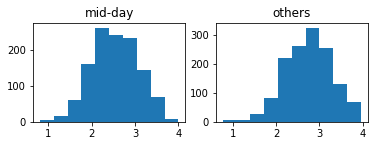

In [65]:
chi_square("mid-day",value_spread2,'start_range')

,start_range,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,late-afteroon,2.000000,10.000000,78.000000,165.000000,202.000000,102.000000,24.00000,85.7246,2.33621e-16
1,Other,16.000000,96.000000,441.000000,631.000000,576.000000,231.000000,13.00000,,
2,Expected,4.056436,23.887901,116.960572,179.384615,175.328179,75.044066,8.33823,,
3,Expected,13.943564,82.112099,402.039428,616.615385,602.671821,257.955934,28.66177,,


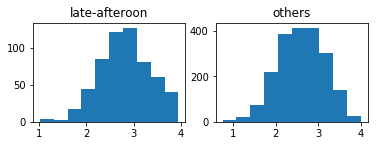

In [66]:
chi_square("late-afteroon",value_spread2,'start_range')

,start_range,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,night,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,5.43228,0.48968
1,Other,18.000000,106.000000,519.000000,796.000000,775.000000,332.000000,37.000000,,
2,Expected,0.027831,0.163896,0.802474,1.230769,1.202938,0.514882,0.057209,,
3,Expected,17.972169,105.836104,518.197526,794.769231,776.797062,332.485118,36.942791,,


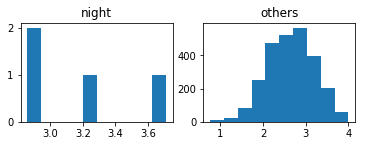

In [67]:
chi_square("night",value_spread2,'start_range')

In [68]:
t_test("early")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,early,2.681843,2.25748,0.0240614,0.00720303,0.0982443
1,Others,2.629120,,,,


In [69]:
t_test("mid-day")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,mid-day,2.536126,-9.64919,1.14346e-21,-0.246304,-0.16317
1,Others,2.740863,,,,


In [70]:
t_test("late-afteroon")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,late-afteroon,2.818113,8.7808,2.89416e-18,0.173697,0.27258
1,Others,2.594975,,,,


In [71]:
t_test("night")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,night,3.167500,1.90869,0.0564132,-0.108471,1.15457
1,Others,2.644452,,,,


# On Department

In [72]:
dist_dept = joined_df.groupby(['Department',"rCourseQualityBinned"]).agg({"term":"count"}).reset_index()

#df = df[['gene_symbol', 'sample_id', 'fc']]
value_spread3 = dist_dept.pivot(index='Department',columns='rCourseQualityBinned',values='term').fillna(0).reset_index()
value_spread3

rCourseQualityBinned,Department,1.0,1.5,2.0,2.5,3.0,3.5,4.0
0,ACCT,1.0,18.0,157.0,109.0,13.0,4.0,0.0
1,BEPP,3.0,26.0,86.0,49.0,20.0,15.0,0.0
2,FNCE,0.0,13.0,60.0,147.0,160.0,43.0,1.0
3,HCMG,0.0,0.0,0.0,12.0,16.0,3.0,0.0
4,LGST,0.0,0.0,16.0,19.0,61.0,76.0,10.0
5,MGMT,3.0,16.0,76.0,158.0,171.0,89.0,18.0
6,MKTG,4.0,5.0,35.0,139.0,198.0,63.0,6.0
7,OIDD,0.0,0.0,9.0,27.0,35.0,16.0,0.0
8,REAL,0.0,0.0,17.0,41.0,40.0,8.0,0.0
9,STAT,7.0,28.0,63.0,95.0,64.0,16.0,2.0


,Department,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,ACCT,1.000000,18.000000,157.00000,109.000000,13.000000,4.000000,0.000000,296.207,5.31508e-61
1,Other,17.000000,88.000000,362.00000,687.000000,765.000000,329.000000,37.000000,,
2,Expected,2.101276,12.374179,60.58678,92.923077,90.821801,38.873599,4.319289,,
3,Expected,15.898724,93.625821,458.41322,703.076923,687.178199,294.126401,32.680711,,


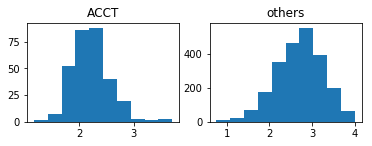

In [73]:
chi_square("ACCT",value_spread3,'Department')

,Department,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,BEPP,3.000000,26.000000,86.000000,49.000000,20.000000,15.000000,0.000000,141.204,5.5837e-28
1,Other,15.000000,80.000000,433.000000,747.000000,758.000000,318.000000,37.000000,,
2,Expected,1.384615,8.153846,39.923077,61.230769,59.846154,25.615385,2.846154,,
3,Expected,16.615385,97.846154,479.076923,734.769231,718.153846,307.384615,34.153846,,


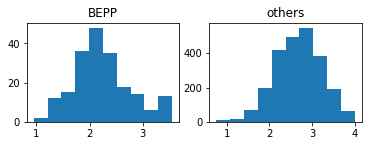

In [74]:
chi_square("BEPP",value_spread3,'Department')

,start_range,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,late-afteroon,2.000000,10.000000,78.000000,165.000000,202.000000,102.000000,24.00000,85.7246,2.33621e-16
1,Other,16.000000,96.000000,441.000000,631.000000,576.000000,231.000000,13.00000,,
2,Expected,4.056436,23.887901,116.960572,179.384615,175.328179,75.044066,8.33823,,
3,Expected,13.943564,82.112099,402.039428,616.615385,602.671821,257.955934,28.66177,,


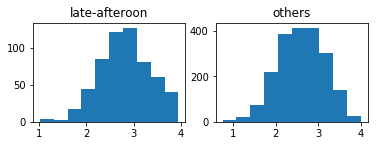

In [75]:
chi_square("late-afteroon",value_spread2,'start_range')

,start_range,1.0,1.5,2.0,2.5,3.0,3.5,4.0,chi_stats,p_value
0,night,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,5.43228,0.48968
1,Other,18.000000,106.000000,519.000000,796.000000,775.000000,332.000000,37.000000,,
2,Expected,0.027831,0.163896,0.802474,1.230769,1.202938,0.514882,0.057209,,
3,Expected,17.972169,105.836104,518.197526,794.769231,776.797062,332.485118,36.942791,,


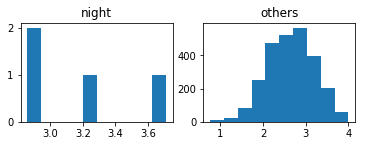

In [76]:
chi_square("night",value_spread2,'start_range')

In [77]:
t_test("ACCT")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,ACCT,2.213808,-15.1936,5.28522e-50,-0.534097,-0.442856
1,Others,2.702284,,,,


In [78]:
t_test("BEPP")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,BEPP,2.234271,-11.2788,7.78521e-29,-0.524547,-0.365931
1,Others,2.679510,,,,


In [79]:
t_test("FNCE")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,FNCE,2.691132,1.88619,0.0593818,0.00538039,0.104346
1,Others,2.636269,,,,


In [80]:
t_test("HCMG")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,HCMG,2.806774,1.65169,0.0987186,0.0574665,0.269478
1,Others,2.643302,,,,


In [81]:
t_test("LGST")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,LGST,3.11478,12.3351,5.20275e-34,0.429861,0.58024
1,Others,2.60973,,,,


In [82]:
t_test("MGMT")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,MGMT,2.767382,5.79728,7.55907e-09,0.100737,0.206586
1,Others,2.613721,,,,


In [83]:
t_test("MKTG")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,MKTG,2.807689,6.98255,3.67144e-12,0.147776,0.245487
1,Others,2.611058,,,,


In [84]:
t_test("OIDD")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,OIDD,2.829425,3.19479,0.00141616,0.0929125,0.288234
1,Others,2.638852,,,,


In [85]:
t_test("REAL")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,REAL,2.681038,0.686392,0.492527,-0.0404148,0.115026
1,Others,2.643732,,,,


In [86]:
t_test("STAT")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,STAT,2.443164,-6.52181,8.32566e-11,-0.296593,-0.155679
1,Others,2.669299,,,,


In [87]:
dist_dept = joined_df.groupby(["race",'Department']).agg({"term":"count"}).reset_index()

#df = df[['gene_symbol', 'sample_id', 'fc']]
value_spread4 = dist_dept.pivot(index='race',columns='Department',values='term').fillna(0).reset_index()
value_spread4['race'] = ['White','Black','Asian','Indian','Others']
value_spread4

Department,race,ACCT,BEPP,FNCE,HCMG,LGST,MGMT,MKTG,OIDD,REAL,STAT
0,White,181.0,137.0,382.0,30.0,157.0,414.0,271.0,55.0,54.0,149.0
1,Black,13.0,0.0,10.0,0.0,13.0,14.0,9.0,3.0,10.0,0.0
2,Asian,65.0,37.0,10.0,0.0,3.0,31.0,113.0,21.0,24.0,92.0
3,Indian,23.0,8.0,14.0,0.0,0.0,63.0,45.0,8.0,18.0,18.0
4,Others,20.0,17.0,8.0,1.0,9.0,9.0,12.0,0.0,0.0,16.0


In [88]:
dist_dept = joined_df.groupby(["Department",'gender']).agg({"term":"count"}).reset_index()

#df = df[['gene_symbol', 'sample_id', 'fc']]
value_spread5 = dist_dept.pivot(index='gender',columns='Department',values='term').fillna(0).reset_index()
value_spread5['gender'] = ['Male','Female']
value_spread5

Department,gender,ACCT,BEPP,FNCE,HCMG,LGST,MGMT,MKTG,OIDD,REAL,STAT
0,Male,222,138,377,18,127,313,226,66,52,225
1,Female,80,61,47,13,55,218,224,21,54,50


,gender,ACCT,BEPP,FNCE,HCMG,LGST,MGMT,MKTG,OIDD,REAL,STAT,chi_stats,p_value
0,Male,222.00000,138.000000,377.000000,18.000000,127.000000,313.000000,226.000000,66.000000,52.000000,225.000000,221.384,1.07068e-42
1,Other,80.00000,61.000000,47.000000,13.000000,55.000000,218.000000,224.000000,21.000000,54.000000,50.000000,,
2,Expected,205.92501,135.692308,289.113259,21.137998,124.100503,362.073444,306.841902,59.322768,72.278315,187.514496,,
3,Expected,96.07499,63.307692,134.886741,9.862002,57.899497,168.926556,143.158098,27.677232,33.721685,87.485504,,


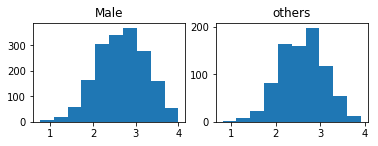

In [89]:
chi_square("Male",value_spread5,'gender')

In [90]:
dist_dept = joined_df.groupby(["Department",'start_range']).agg({"term":"count"}).reset_index()

#df = df[['gene_symbol', 'sample_id', 'fc']]
value_spread6 = dist_dept.pivot(index='start_range',columns='Department',values='term').fillna(0).reset_index()
value_spread6

Department,start_range,ACCT,BEPP,FNCE,HCMG,LGST,MGMT,MKTG,OIDD,REAL,STAT
0,early,104.0,53.0,186.0,9.0,54.0,129.0,123.0,34.0,39.0,61.0
1,late-afteroon,19.0,31.0,53.0,2.0,69.0,130.0,169.0,16.0,30.0,64.0
2,mid-day,179.0,115.0,185.0,20.0,58.0,272.0,158.0,37.0,37.0,147.0
3,night,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0


,start_range,ACCT,BEPP,FNCE,HCMG,LGST,MGMT,MKTG,OIDD,REAL,STAT,chi_stats,p_value
0,mid-day,179.000000,115.000000,185.000000,20.000000,58.000000,272.000000,158.000000,37.000000,37.000000,147.000000,90.8677,1.09022e-15
1,Other,123.000000,84.000000,239.000000,11.000000,124.000000,259.000000,292.000000,50.000000,69.000000,128.000000,,
2,Expected,141.018941,92.923077,197.986857,14.475454,84.984925,247.950522,210.127561,40.624662,49.496714,128.411287,,
3,Expected,160.981059,106.076923,226.013143,16.524546,97.015075,283.049478,239.872439,46.375338,56.503286,146.588713,,


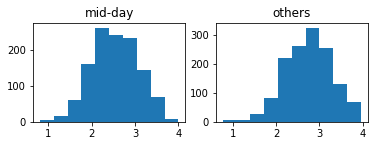

In [91]:
chi_square("mid-day",value_spread6,'start_range')

In [92]:
def t_test_layered(x,y):
    mean1 = joined_df[(joined_df[x] == 1)&(joined_df[y] == 1)]['rCourseQuality'].mean()
    mean2 = joined_df[(joined_df[x] == 0)&(joined_df[y] == 1)]['rCourseQuality'].mean()
    t_test_result = stats.ttest_ind(joined_df[(joined_df[x] == 1)&(joined_df[y] == 1)]['rCourseQuality'],
                          joined_df[(joined_df[x] == 0)|(joined_df[y] == 0)]['rCourseQuality'])
    cm = sms.CompareMeans(sms.DescrStatsW(joined_df[(joined_df[x] == 1)&(joined_df[y] == 1)]['rCourseQuality']), 
                          sms.DescrStatsW(joined_df[(joined_df[x] == 0)|(joined_df[y] == 0)]['rCourseQuality']))
    t_test_conf = cm.tconfint_diff(usevar='unequal')
    return pd.DataFrame({"of_interest" : [x + y, "Other" + y],
                        "mean":[mean1, mean2],
                          "t_stats":[t_test_result[0],""],
                         "p_value":[t_test_result[1],""],
                         "conf_interval_lb" :[t_test_conf[0],""],
                         "conf_interval_ub" :[t_test_conf[1],""]})

In [93]:
t_test_layered("Asian","STAT")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,AsianSTAT,2.095652,-9.98198,4.74999e-23,-0.670862,-0.468887
1,OtherSTAT,2.617869,,,,


In [94]:
t_test_layered("Asian","ACCT")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,AsianACCT,2.176308,-7.05417,2.22044e-12,-0.55501,-0.407069
1,OtherACCT,2.224093,,,,


In [95]:
t_test_layered("Asian","BEPP")

,of_interest,mean,t_stats,p_value,conf_interval_lb,conf_interval_ub
0,AsianBEPP,2.157838,-5.48072,4.64567e-08,-0.577363,-0.411628
1,OtherBEPP,2.251728,,,,
